In [46]:
import pandas as pd 
import polars as pl 
import numpy as np 
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import yfinance as yf
import pandas as pd
import pytz
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import pandas as pd
import emoji
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import pandas as pd


# Loading the data

In [138]:
 
# Load the data
df = pd.read_parquet('balanced_250k.parquet')

# Assume 'datetime_column' is the name of your datetime column
# Ensure the column is timezone-aware and set to UTC
df['date'] = pd.to_datetime(df['date'])

# Convert the timezone from UTC to Eastern Standard Time (EST)
df['date'] = df['date'].dt.tz_convert('America/New_York')

# View the DataFrame to confirm changes
print(df)


                             date  \
139036  2017-05-09 16:32:06-04:00   
981796  2023-02-08 16:31:58-05:00   
359413  2022-05-13 04:55:11-04:00   
2199286 2019-09-18 02:02:46-04:00   
225978  2023-06-05 09:57:33-04:00   
...                           ...   
1353599 2019-08-13 15:38:54-04:00   
1502926 2013-03-12 14:39:41-04:00   
1767016 2021-09-02 10:25:34-04:00   
1801456 2023-11-02 15:59:27-04:00   
455770  2022-02-05 00:29:12-05:00   

                                                   content  true_sentiment  \
139036   $AAPL I wanna sell some shares to buy me an #a...             1.0   
981796   $HOOD Don't forget $AAPL tomorrow, headed to 157+             1.0   
359413   $AAPL Another fake upside move…   \nTake profi...             0.0   
2199286        $AAPL iPhone 11 preorder goes well in China             1.0   
225978   $SPY $AAPL Headlines and clickbait articles li...             0.0   
...                                                    ...             ...   
1353599  

# Predicting using a Naive Bayes with Unigrams and no text preprocessing 

In [185]:


def to_string(value):
    """
    Converts any input value to a string, even if it is None.
    
    Args:
    value: Any input value.
    
    Returns:
    A string representation of the input.
    """
    return "None" if value is None else str(value)

def train_sentiment_model(dataframe):
    """
    Trains a Naive Bayes sentiment classifier on the 'content' column of a dataframe.
    
    Args:
    dataframe: A pandas DataFrame with columns 'content' and 'true_sentiment'.
    
    Returns:
    A trained Multinomial Naive Bayes model.
    """
    # Ensure all content is string
    dataframe['content'] = dataframe['content'].apply(to_string)
    
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(dataframe['content'], dataframe['true_sentiment'], test_size=0.2, random_state=42)
    
    # Creating a pipeline with CountVectorizer and MultinomialNB
    model = make_pipeline(CountVectorizer(ngram_range=(1, 1)), MultinomialNB())
    
    # Training the model
    model.fit(X_train, y_train)
    
    # Evaluating the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy: {accuracy}")
    
    return model

def predict_sentiment(text, model):
    """
    Predicts the sentiment of a given text using a trained Naive Bayes model.
    
    Args:
    text: A string, the text to predict sentiment for.
    model: A trained model.
    
    Returns:
    The predicted sentiment.
    """
    return model.predict([text])

df['content']= df['content'].astype('str')
df = df.dropna()
model = train_sentiment_model(df)

df['NB_prediction'] = df['content'].apply(lambda x: predict_sentiment(x, model))


df['NB_prediction']= df['NB_prediction'].astype('str')
df['NB_prediction_1'] = df['NB_prediction'].str.replace(']', '').str.replace('[', '').str.replace('.', '')
df['NB_prediction_1']= df['NB_prediction_1'].astype('int')


# Preprocess, interpert empojis and use bigrams 

In [269]:

def preprocess_text(text):
    """
    Clean and preprocess text data.
    - Convert text to lowercase.
    - Replace emojis with word equivalents.
    - Remove unwanted characters and numbers.
    """
    # Convert emojis to words
    text = emoji.demojize(text)
    # Remove all characters that are not alphabetic
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert text to lowercase
    text = text.lower()
    return text

def train_sentiment_model_bigram(dataframe):
    """
    Trains a Naive Bayes sentiment classifier on the 'content' column of a dataframe.
    
    Args:
    dataframe: A pandas DataFrame with columns 'content' and 'true_sentiment'.
    
    Returns:
    A trained Multinomial Naive Bayes model.
    """
    # Ensure all content is string and preprocess text
    dataframe['content'] = dataframe['content'].astype(str).apply(preprocess_text)
    
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(dataframe['content'], dataframe['true_sentiment'], test_size=0.2, random_state=42)
    
    # Creating a pipeline with CountVectorizer and MultinomialNB
    model = make_pipeline(CountVectorizer(ngram_range=(1, 2)), MultinomialNB())
    
    # Training the model
    model.fit(X_train, y_train)
    
    # Evaluating the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy: {accuracy}")
    
    return model

def predict_sentiment(text, model):
    """
    Predicts the sentiment of a given text using a trained Naive Bayes model.
    
    Args:
    text: A string, the text to predict sentiment for.
    model: A trained model.
    
    Returns:
    The predicted sentiment.
    """
    # Preprocess the text
    processed_text = preprocess_text(text)
    return model.predict([processed_text])

# Assuming df is already defined
df['content'] = df['content'].astype('str')
model = train_sentiment_model_bigram(df)


Model accuracy: 0.7831


In [270]:
df['NB_prediction_bigram'] = df['content'].apply(lambda x: predict_sentiment(x, model))
df['NB_prediction_bigram'] = df['NB_prediction_bigram'].astype('str')
df['NB_prediction_bigram'] = df['NB_prediction_bigram'].str.replace(']', '').str.replace('[', '').str.replace('.', '')
df['NB_prediction_bigram']= df['NB_prediction_bigram'].astype('int')

In [273]:

# Assuming df['date'] is already in a datetime format, if not, convert it:
df['date'] = pd.to_datetime(df['date'])

# Correcting the method to set start_time and end_time
df['start_time'] = df['date'].dt.floor('d') - pd.Timedelta(days=1) + pd.Timedelta(hours=16)  # 4 PM on day t-1
df['end_time'] = df['date'].dt.floor('d') + pd.Timedelta(hours=16)  # 4 PM on day t

# Filtering messages to check if 'date' is within the calculated start and end times
df['is_within_range'] = (df['date'] >= df['start_time']) & (df['date'] < df['end_time'])
filtered_df = df[df['is_within_range']]


In [274]:
start_date = df['date1'].min().strftime('%Y-%m-%d')
end_date = df['date1'].max().strftime('%Y-%m-%d')

# Fetch the stock data from Yahoo Finance
data = yf.download('AAPL', start=start_date, end=end_date)

# Reset index to merge on 'Date'
data.reset_index(inplace=True)

# Merge the original DataFrame with the fetched stock data
result_df = pd.merge(df[df['is_within_range']==True], data[["Date",'Close']], left_on='date1', right_on='Date', how='left')
result_df = result_df.drop('NB_prediction', axis=1)

[*********************100%%**********************]  1 of 1 completed


In [275]:
bull = result_df[result_df['NB_prediction_1']==1].groupby('Date')['NB_prediction_1'].count().reset_index()
bear = result_df[result_df['NB_prediction_1']==0].groupby('Date')['NB_prediction_1'].count().reset_index()
price = result_df.groupby('Date')['Close'].max().reset_index()

model_df = bull.merge(bear, on = 'Date', how = 'left').merge(price, on = 'Date', how = 'left').rename(columns = {"NB_prediction_1_x":'Bullish_count', "NB_prediction_1_y": "Bearish_count", "Close": "Closing_Price"})
bull2 = result_df[result_df['NB_prediction_bigram']==1].groupby('Date')['NB_prediction_1'].count().reset_index()
bear2 = result_df[result_df['NB_prediction_bigram']==0].groupby('Date')['NB_prediction_1'].count().reset_index()
model_df['Postive_ratio'] = model_df['Bullish_count']/ (model_df['Bullish_count'] + model_df['Bearish_count'])
model_df['Return'] = model_df['Closing_Price'].pct_change()
model_df = model_df.merge(bull2, on = 'Date', how = 'left').merge(bear2, on='Date', how ='left').rename(columns = {"NB_prediction_1_x": "Bullish_count_bigram","NB_prediction_1_y":"Bearish_count_bigram"})
model_df['Postive_ratio_bigram'] = model_df['Bullish_count_bigram']/ (model_df['Bullish_count_bigram'] + model_df['Bearish_count_bigram'])


In [277]:
bull = result_df[result_df['NB_prediction_bigram']==1].groupby('Date')['NB_prediction_1'].count().reset_index()
bear = result_df[result_df['NB_prediction_bigram']==0].groupby('Date')['NB_prediction_1'].count().reset_index()

model_df = model_df.merge(bear, on = 'Date', how = 'left').merge(bull, on = 'Date', how = 'left').rename(columns = {"NB_prediction_1_x":'Bullish_count', "NB_prediction_1_y": "Bearish_count",})

# Plots 

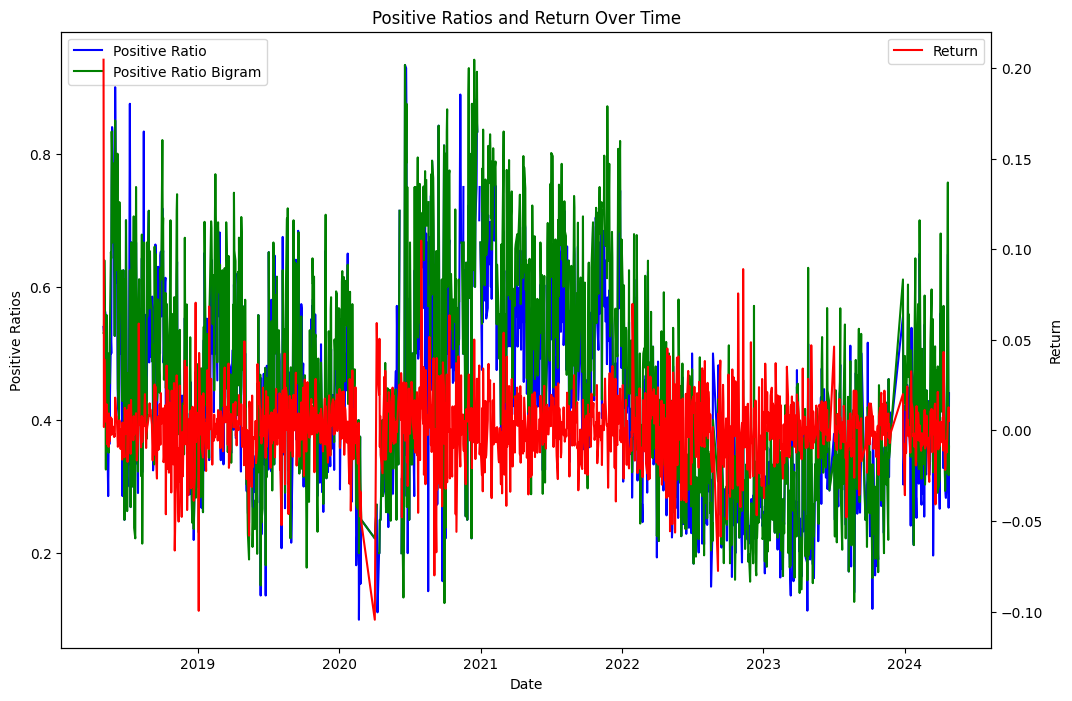

In [294]:
years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]

filtered_df = model_df[model_df['Date'].dt.year.isin(years)]
import matplotlib.pyplot as plt

# Create a new figure and a subplot with shared x-axis, specifying a larger figure size
fig, ax1 = plt.subplots(figsize=(12, 8))  # You can adjust the dimensions as needed

# Plotting 'Postive_ratio' and 'Postive_ratio_bigram' on the primary y-axis (left)
ax1.plot(filtered_df.Date, filtered_df['Postive_ratio'], label='Positive Ratio', color='b')
ax1.plot(filtered_df.Date, filtered_df['Postive_ratio_bigram'], label='Positive Ratio Bigram', color='g')

# Labeling the primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Positive Ratios')
ax1.legend(loc='upper left')

# Creating another y-axis (secondary) that shares the same x-axis
ax2 = ax1.twinx()  
ax2.plot(filtered_df.Date, filtered_df['Return'], label='Return', color='r')

# Labeling the secondary y-axis
ax2.set_ylabel('Return')
ax2.legend(loc='upper right')

# Adding a title and showing the plot
plt.title('Positive Ratios and Return Over Time')
plt.show()


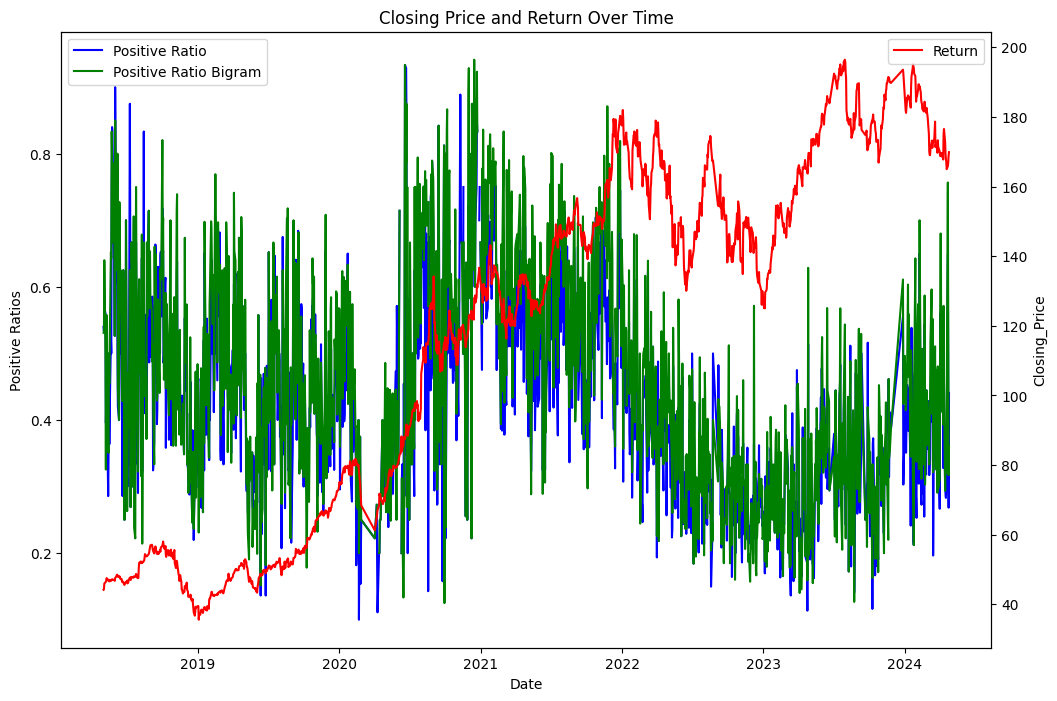

In [296]:
years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]

filtered_df = model_df[model_df['Date'].dt.year.isin(years)]
import matplotlib.pyplot as plt

# Create a new figure and a subplot with shared x-axis, specifying a larger figure size
fig, ax1 = plt.subplots(figsize=(12, 8))  # You can adjust the dimensions as needed

# Plotting 'Postive_ratio' and 'Postive_ratio_bigram' on the primary y-axis (left)
ax1.plot(filtered_df.Date, filtered_df['Postive_ratio'], label='Positive Ratio', color='b')
ax1.plot(filtered_df.Date, filtered_df['Postive_ratio_bigram'], label='Positive Ratio Bigram', color='g')

# Labeling the primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Positive Ratios')
ax1.legend(loc='upper left')

# Creating another y-axis (secondary) that shares the same x-axis
ax2 = ax1.twinx()  
ax2.plot(filtered_df.Date, filtered_df['Closing_Price'], label='Return', color='r')

# Labeling the secondary y-axis
ax2.set_ylabel('Closing_Price')
ax2.legend(loc='upper right')

# Adding a title and showing the plot
plt.title('Closing Price and Return Over Time')
plt.show()


In [289]:
filtered_df[['Postive_ratio_bigram','Postive_ratio','Return','Closing_Price']].corr()

,Postive_ratio_bigram,Postive_ratio,Return,Closing_Price
Postive_ratio_bigram,1.000000,0.836012,0.387585,0.351200
Postive_ratio,0.836012,1.000000,0.344269,0.387706
Return,0.387585,0.344269,1.000000,0.145902
Closing_Price,0.351200,0.387706,0.145902,1.000000


# Regression 1 Predict forward sentiment using past sentiment and past returns ( Unigram method) 

In [298]:
import pandas as pd
import statsmodels.api as sm
years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]

filtered_df = model_df[model_df['Date'].dt.year.isin(years)]
# Creating lagged variables for the DataFrame
filtered_df['Postive_ratio_lag1'] = filtered_df['Postive_ratio'].shift(1)
filtered_df['Postive_ratio_bigram_lag1'] = filtered_df['Postive_ratio_bigram'].shift(1)
filtered_df['Return_lag1'] = filtered_df['Return'].shift(1)

# Dropping rows with any NaN values resulting from the shift operation
filtered_df = filtered_df.dropna()

# Define the model
X = filtered_df[['Postive_ratio_lag1', 'Return_lag1']]
X = sm.add_constant(X)  # adding a constant for the intercept
y = filtered_df['Postive_ratio']

# Fit the model
model1 = sm.OLS(y, X).fit(cov_type='HC0')

# Print the summary of the regression
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:          Postive_ratio   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     338.3
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          1.89e-120
Time:                        18:44:53   Log-Likelihood:                 1048.4
No. Observations:                1394   AIC:                            -2091.
Df Residuals:                    1391   BIC:                            -2075.
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1655      0

C:\Users\zgcha\AppData\Local\Temp\ipykernel_15268\3555899524.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Postive_ratio_lag1'] = filtered_df['Postive_ratio'].shift(1)
C:\Users\zgcha\AppData\Local\Temp\ipykernel_15268\3555899524.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Postive_ratio_bigram_lag1'] = filtered_df['Postive_ratio_bigram'].shift(1)
C:\Users\zgcha\AppData\Local\Temp\ipykernel_15268\3555899524.py:9: SettingWithCopyWarning: 
A value is trying to be set on a

# Regression 2 Predict forward sentiment using past sentiment and past returns ( Bigram method) 

In [299]:
# Define the model
X = filtered_df[['Postive_ratio_bigram_lag1', 'Return_lag1']]
X = sm.add_constant(X)  # adding a constant for the intercept
y = filtered_df['Postive_ratio_bigram']

# Fit the model
model2 = sm.OLS(y, X).fit(cov_type='HC0')

# Print the summary of the regression
print(model2.summary())


                             OLS Regression Results                             
Dep. Variable:     Postive_ratio_bigram   R-squared:                       0.409
Model:                              OLS   Adj. R-squared:                  0.408
Method:                   Least Squares   F-statistic:                     424.7
Date:                  Sun, 28 Apr 2024   Prob (F-statistic):          1.09e-144
Time:                          18:44:58   Log-Likelihood:                 909.52
No. Observations:                  1394   AIC:                            -1813.
Df Residuals:                      1391   BIC:                            -1797.
Df Model:                             2                                         
Covariance Type:                    HC0                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
co

# Regression 3 Predict forward returns using past sentiment and past returns ( Unigram method) 

In [300]:
import pandas as pd
import statsmodels.api as sm
years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]

filtered_df = model_df[model_df['Date'].dt.year.isin(years)]
# Creating lagged variables for the DataFrame
filtered_df['Postive_ratio_lag1'] = filtered_df['Postive_ratio'].shift(1)
filtered_df['Postive_ratio_bigram_lag1'] = filtered_df['Postive_ratio_bigram'].shift(1)
filtered_df['Return_lag1'] = filtered_df['Return'].shift(1)

# Dropping rows with any NaN values resulting from the shift operation
filtered_df = filtered_df.dropna()

# Define the model
X = filtered_df[['Postive_ratio_lag1', 'Return_lag1']]
X = sm.add_constant(X)  # adding a constant for the intercept
y = filtered_df['Return']

# Fit the model
model1 = sm.OLS(y, X).fit(cov_type='HC0')

# Print the summary of the regression
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1490
Date:                Sun, 28 Apr 2024   Prob (F-statistic):              0.862
Time:                        18:49:53   Log-Likelihood:                 3561.7
No. Observations:                1394   AIC:                            -7117.
Df Residuals:                    1391   BIC:                            -7102.
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0011      0

C:\Users\zgcha\AppData\Local\Temp\ipykernel_15268\2877884785.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Postive_ratio_lag1'] = filtered_df['Postive_ratio'].shift(1)
C:\Users\zgcha\AppData\Local\Temp\ipykernel_15268\2877884785.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Postive_ratio_bigram_lag1'] = filtered_df['Postive_ratio_bigram'].shift(1)
C:\Users\zgcha\AppData\Local\Temp\ipykernel_15268\2877884785.py:9: SettingWithCopyWarning: 
A value is trying to be set on a

# Regression 4 Predict forward returns using past sentiment and past returns ( Bigram method) 

In [301]:
# Define the model
X = filtered_df[['Postive_ratio_bigram_lag1', 'Return_lag1']]
X = sm.add_constant(X)  # adding a constant for the intercept
y = filtered_df['Return']

# Fit the model
model2 = sm.OLS(y, X).fit(cov_type='HC0')

# Print the summary of the regression
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1790
Date:                Sun, 28 Apr 2024   Prob (F-statistic):              0.836
Time:                        18:49:57   Log-Likelihood:                 3561.8
No. Observations:                1394   AIC:                            -7118.
Df Residuals:                    1391   BIC:                            -7102.
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 